In [1]:
import pandas as pd

import random
import numpy as np
import glob
import torch
import torch.nn.functional as F
import torch.nn as nn

from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms

# Visualization tools
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from PIL import Image
from torchvision.utils import save_image, make_grid

import math

# Setting reproducibility
SEED = 1
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


In [2]:
df = pd.read_excel("./Cholangitis AH Database.xlsx", sheet_name = 'Sheet1' )

print(df.columns)
df.head()

Index(['Date of admission', 'WBC', 'Hgb', 'MCV', 'Plt', 'Alb', 'AST', 'ALT',
       'AP', 'Tb', 'Db', 'Class'],
      dtype='object')


,Date of admission,WBC,Hgb,MCV,Plt,Alb,AST,ALT,AP,Tb,Db,Class
0,2015-11-06 00:00:00,7.5,11.8,92.6,127.0,3.0,596,107,208.0,25.7,25.1,1
1,09/23/2017,20.0,14.3,79.0,426.0,4.2,269,118,569.0,13.0,6.3,1
2,2016-04-08 00:00:00,11.2,15.5,85.2,194.0,3.7,77,122,253.0,12.5,9.4,1
3,04/07/2019,9.8,13.5,90.7,274.0,4.0,129,237,390.0,12.0,7.5,1
4,2019-10-21 00:00:00,12.1,12.9,98.9,139.0,3.7,163,331,392.0,11.3,8.7,1


In [3]:
AllFeatures = ['WBC', 'Hgb', 'MCV', 'Plt', 'Alb', 'AST', 'ALT', 'AP',
       'Tb', 'Db', 'Class']
df = df[AllFeatures]

print("size of dataframe: ", df.shape[0])
print("size of Chol: ", sum(df['Class'] == 1)) # Chol
print("size of AH: ", sum(df['Class'] == 0)) # AH

df = df.dropna()
print("size of dataframe after dropping NA: ", df.shape[0])

print("size of Chol: ", sum(df['Class'] == 1)) # Chol
print("size of AH: ", sum(df['Class'] == 0)) # AH


size of dataframe:  459
size of Chol:  194
size of AH:  265
size of dataframe after dropping NA:  454
size of Chol:  194
size of AH:  260


In [4]:
SelectedFeatures = ['WBC', 'Hgb', 'MCV', 'Plt', 'Alb', 'AST', 'ALT', 'AP',
       'Tb', 'Db']

X = df[SelectedFeatures].values
y = df['Class'].values
print(type(X), type(y), X.shape, y.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> (454, 10) (454,)


#### External set

In [5]:
# Mimic_AH_Chol_cleaned_20201229
df_external = pd.read_csv("./Mimic_AH_Chol_cleaned_20201229.csv")

print(df_external.columns)
print('Number of total external data:', len(df_external))
print('Number of total external data without nan:', len(df_external.dropna()))
df_external.head()

df_external_nodups = df_external.drop_duplicates()
print('Number of data without duplication', len(df_external_nodups))


Index(['subject_id', 'hadm_id', 'c_cat', 'WBC', 'Hgb', 'MCV', 'Plt', 'ALB',
       'TB', 'DB', 'ALT', 'AST', 'AP'],
      dtype='object')
Number of total external data: 305
Number of total external data without nan: 170
Number of data without duplication 305


In [6]:
df_external.head()

,subject_id,hadm_id,c_cat,WBC,Hgb,MCV,Plt,ALB,TB,DB,ALT,AST,AP
0,413,156909,Chol,15.3,13.3,111,120,3.4,4.6,6.2,111,94,195
1,507,148905,Chol,11.4,12.0,90,95,3.1,5.8,3.8,232,185,96
2,590,172260,AH,16.0,7.5,100,298,2.0,20.4,14.8,32,112,523
3,1032,180157,Chol,21.2,12.3,92,280,2.7,4.9,NaN,269,218,369
4,1076,141828,Chol,6.1,15.7,85,149,3.9,3.2,NaN,281,464,179


In [7]:
SelectedFeatures = ['WBC', 'Hgb', 'MCV', 'Plt', 'ALB', 'AST', 'ALT', 'AP',
       'TB', 'DB']
# SelectedFeatures = ['WBC', 'Hgb', 'MCV', 'Plt', 'ALB', 'AST', 'ALT', 'AP',
#        'TB']

df_external_temp = df_external[np.concatenate([['c_cat'], SelectedFeatures])]
df_external_dropna = df_external_temp.dropna()
extX = df_external_dropna[SelectedFeatures].values
exty_name = df_external_dropna['c_cat'].values
exty = np.ones(len(exty_name))*-1
print(len(exty), len(exty_name))

print(exty_name)
exty[exty_name == 'AH'] = 0
exty[exty_name == 'Chol'] = 1
exty = exty.astype('int64')

# # # print(exty_name, exty, y)
# # print(type(extX), type(exty))
# # print(type(exty[0]))

170 170
['Chol' 'Chol' 'AH' 'AH' 'Chol' 'AH' 'Chol' 'AH' 'AH' 'Chol' 'Chol' 'Chol'
 'Chol' 'Chol' 'AH' 'Chol' 'Chol' 'AH' 'AH' 'Chol' 'Chol' 'AH' 'Chol'
 'Chol' 'Chol' 'Chol' 'Chol' 'AH' 'Chol' 'AH' 'Chol' 'Chol' 'Chol' 'Chol'
 'AH' 'Chol' 'Chol' 'Chol' 'Chol' 'Chol' 'Chol' 'Chol' 'Chol' 'AH' 'Chol'
 'Chol' 'Chol' 'Chol' 'Chol' 'Chol' 'Chol' 'Chol' 'Chol' 'AH' 'AH' 'Chol'
 'AH' 'Chol' 'AH' 'Chol' 'Chol' 'Chol' 'Chol' 'AH' 'AH' 'Chol' 'Chol'
 'Chol' 'AH' 'Chol' 'Chol' 'Chol' 'Chol' 'AH' 'Chol' 'AH' 'Chol' 'AH' 'AH'
 'Chol' 'AH' 'Chol' 'Chol' 'Chol' 'Chol' 'AH' 'AH' 'AH' 'Chol' 'Chol' 'AH'
 'Chol' 'Chol' 'Chol' 'AH' 'AH' 'Chol' 'AH' 'AH' 'Chol' 'Chol' 'Chol'
 'Chol' 'AH' 'Chol' 'Chol' 'Chol' 'AH' 'Chol' 'Chol' 'Chol' 'Chol' 'Chol'
 'Chol' 'Chol' 'AH' 'Chol' 'AH' 'Chol' 'Chol' 'Chol' 'Chol' 'AH' 'Chol'
 'AH' 'AH' 'AH' 'AH' 'Chol' 'Chol' 'Chol' 'AH' 'Chol' 'AH' 'AH' 'AH'
 'Chol' 'Chol' 'Chol' 'AH' 'AH' 'AH' 'AH' 'AH' 'Chol' 'Chol' 'AH' 'Chol'
 'Chol' 'Chol' 'AH' 'AH' 'AH' 'Chol' 'AH' 'Chol

In [8]:
exty
print(sum(exty == 0), sum(exty == 1))

59 111


In [9]:
print(np.mean(X, axis=0))
print(np.mean(extX, axis=0))
print(np.std(X, axis=0))
print(np.std(extX, axis=0))
print(X.shape, y.shape, extX.shape, exty.shape)

[ 13.01442731  11.96035242  96.46475771 179.1685022    3.49207048
 263.530837   172.92070485 283.6660793   11.14008811   8.21563877]
[ 15.03294118  11.54823529  94.34117647 191.35294118   2.98823529
 276.58823529 203.71176471 285.55294118  10.57176471   7.77823529]
[  7.19077634   2.44975336  12.1598509   96.35850323   6.49480841
 246.27258754 207.78622924 199.31421377  10.06190863   7.47069738]
[  8.47724134   2.08366825   9.77578394 113.1944403    0.60980455
 455.68265    242.44294509 229.88907841   9.48938865   7.06265634]
(454, 10) (454,) (170, 10) (170,)


In [10]:
# Getting device
run_gpu = 0    # 0,1,2,3,...
dev = 'cuda:' + str(run_gpu)
# dev='cpu'

print(torch.cuda.is_available())
device = torch.device(dev if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\t" + (f"{torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "CPU"))

True
Using device: cuda:0	Quadro RTX 8000


In [11]:
def draw_data(data_0, data_1, feature1, feature2, \
              feature_names=['WBC', 'Hgb', 'MCV', 'Plt', 'Alb', 'AST', 'ALT', 'AP', 'Tb', 'Db'], \
              title_str='Data'):
    # function for scattering data
    
    # create a figure and axis
    fig, ax = plt.subplots()

    # Scatter data points in 2-dimensional space
#     ax.scatter(data_0[:,feature1], data_0[:,feature2], label='class 0', c='red', alpha=.3)
#     ax.scatter(data_1[:,feature1], data_1[:,feature2], label='class 1', marker='^', c='blue', alpha=.3)
    ax.scatter(data_0[:,feature1], data_0[:,feature2], label='AH', c='red', alpha=.3)
    ax.scatter(data_1[:,feature1], data_1[:,feature2], label='Chol', marker='^', c='blue', alpha=.3)
    # set a title and labels
    ax.set_title(title_str)
    ax.set_xlabel(feature_names[feature1])
    ax.set_ylabel(feature_names[feature2])
    ax.legend()


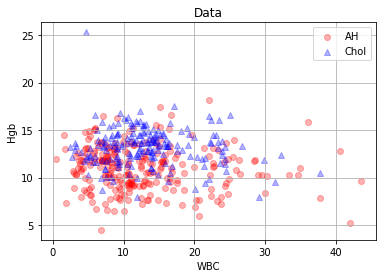

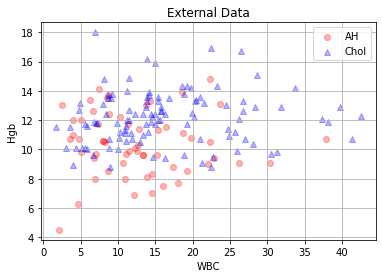

In [12]:
draw_data(X[y == 0], X[y == 1], feature1 = 0, feature2 = 1, title_str='Data')
# plt.xlim(-3, 3)
# plt.ylim(-3, 3)
plt.grid(True)

draw_data(extX[exty == 0], extX[exty == 1], feature1 = 0, feature2 = 1, title_str='External Data')
# plt.xlim(-3, 3)
# plt.ylim(-3, 3)
plt.grid(True)


## Diffusion

In [13]:
labels = torch.tensor(y).float().to(dev)
# data = torch.tensor(X).float().to(dev)
data = torch.log(torch.tensor(X).float().to(dev))
print(labels.shape, data.shape)

torch.Size([454]) torch.Size([454, 10])


In [14]:
# DDPM class
class MyDDPM(nn.Module):
    def __init__(self, network, n_steps=200, min_beta=10 ** -4, max_beta=0.02, device=None):
        super(MyDDPM, self).__init__()
        self.n_steps = n_steps
        self.device = device
        self.network = network.to(device)
        self.betas = torch.linspace(min_beta, max_beta, n_steps).to(
            device)  # Number of steps is typically in the order of thousands
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i + 1]) for i in range(len(self.alphas))]).to(device)

    def forward(self, x0, t, eta=None):
        # Make input image more noisy (we can directly skip to the desired step)
        n, c, h, w = x0.shape
        a_bar = self.alpha_bars[t]

        if eta is None:
            eta = torch.randn(n, c, h, w).to(self.device)

        noisy = a_bar.sqrt().reshape(n, 1, 1, 1) * x0 + (1 - a_bar).sqrt().reshape(n, 1, 1, 1) * eta
        return noisy

    def backward(self, x, t):
        # Run each image through the network for each timestep t in the vector t.
        # The network returns its estimation of the noise that was added.
        return self.network(x, t)
    
    def backward_cfg(self, x, t, c, c_mask):   # Classifier-free guidance
        return self.network(x, t, c, c_mask)

#### Diffusion schedule:

T: number of diffusion steps

B_start, B_end: parameters for $\beta$ (noise) schedule

B_start: Initial $\beta$

B_end: final $\beta$

In [15]:
# Diffuse data
T_col = 8
# T_row = 10
T_row = 100
T = T_col*T_row
B_start = 0.0001
B_end = 0.02


In [16]:
class EmbedBlock(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedBlock, self).__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
#             nn.Unflatten(1, (emb_dim, 1, 1)),
            nn.Unflatten(1, (emb_dim,))  # Noh, corrected
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)

In [17]:
class SinusoidalPositionEmbedBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [18]:
class epsilon_diffuse(nn.Module): # all the dependencies from torch will be given to this class [parent class] # nn.Module contains all the building block of neural networks:
  def __init__(self, input_dim, output_dim, T, ns_layer=[10,5,3], t_embed_dim=8, c_embed_dim=3):
    super(epsilon_diffuse,self).__init__()  # building connection with parent and child classes
    self.T = T
    self.fc1=nn.Linear(input_dim, ns_layer[0], bias=True)       # hidden layer 1
    self.fc2=nn.Linear(ns_layer[0], ns_layer[1], bias=True)     # hidden layer 2
    self.fc3=nn.Linear(ns_layer[1], ns_layer[2], bias=True)     # hidden layer 3
    self.fc4=nn.Linear(ns_layer[2], output_dim)          # last layer

    self.sinusoidaltime = SinusoidalPositionEmbedBlock(t_embed_dim)
    self.t_emb1 = EmbedBlock(t_embed_dim, ns_layer[0])
    self.t_emb2 = EmbedBlock(t_embed_dim, ns_layer[1])
    self.c_embed1 = EmbedBlock(c_embed_dim, ns_layer[0])  # dim n_classes -> dim layer
    self.c_embed2 = EmbedBlock(c_embed_dim, ns_layer[1])  # dim n_classes -> dim layer

  def forward(self, x, t, c, c_mask):
    t = t.float() / self.T  # Convert from [0, T] to [0, 1]
    t = self.sinusoidaltime(t)
    t_emb1 = self.t_emb1(t)
    t_emb2 = self.t_emb2(t)

    c = c*c_mask
    c_emb1 = self.c_embed1(c)
    c_emb2 = self.c_embed2(c)

    out=torch.relu(self.fc1(x))              # input * weights + bias for layer 1
    out=torch.relu(self.fc2(c_emb1*out + t_emb1))            # input * weights + bias for layer 2
    out=torch.relu(self.fc3(c_emb2*out + t_emb2))            # input * weights + bias for layer 3
    out=self.fc4(out)                        # input * weights + bias for last layer
    return out                               # final outcome


### Initiating the model

In [19]:
# DDPM class
class MyDDPM(nn.Module):
    def __init__(self, network, n_steps=200, min_beta=10 ** -4, max_beta=0.02, device=None):
        super(MyDDPM, self).__init__()
        self.n_steps = n_steps
        self.device = device
        self.network = network.to(device)
        self.betas = torch.linspace(min_beta, max_beta, n_steps).to(
            device)  # Number of steps is typically in the order of thousands
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i + 1]) for i in range(len(self.alphas))]).to(device)

    def forward(self, x0, t, eta=None):
        # Make input image more noisy (we can directly skip to the desired step)
        n, d = x0.shape
        a_bar = self.alpha_bars[t]

        if eta is None:
            eta = torch.randn(n, d).to(self.device)

        noisy = a_bar.sqrt().reshape(n, 1) * x0 + (1 - a_bar).sqrt().reshape(n, 1) * eta
        return noisy

    def backward(self, x, t):
        # Run each image through the network for each timestep t in the vector t.
        # The network returns its estimation of the noise that was added.
        return self.network(x, t)
    
    def backward_cfg(self, x, t, c, c_mask):   # Classifier-free guidance
        return self.network(x, t, c, c_mask)

In [55]:
# Defining model
n_steps, min_beta, max_beta = 1000, 10 ** -4, 0.02  # Originally used by the authors
input_dim=data.shape[1]
output_dim=data.shape[1]

# ddpm = MyDDPM(epsilon_diffuse(input_dim, output_dim, T, ns_layer=[50,50,3], c_embed_dim=2), \
#               n_steps=n_steps, min_beta=min_beta, max_beta=max_beta, device=device)
ddpm = MyDDPM(epsilon_diffuse(input_dim, output_dim, T, ns_layer=[2000,2000,2000,2000,2000,2000], c_embed_dim=2), \
              n_steps=n_steps, min_beta=min_beta, max_beta=max_beta, device=device)


In [21]:
sum([p.numel() for p in ddpm.parameters()])

24102010

### Training

In [22]:
def get_context_mask(c, drop_prob, n_classes=2, device='cpu'):
    c_hot = F.one_hot(c.to(torch.int64), num_classes=n_classes).to(device)
    c_mask = torch.bernoulli(torch.ones_like(c_hot).float() - drop_prob).to(device)
    return c_hot, c_mask

In [23]:
def training_loop_cfg(ddpm, data, labels, n_epochs, optim, device, n_classes=10, c_drop_prob=0.1, display=False, store_path="ddpm_model.pt"):
    mse = nn.MSELoss()
    best_loss = float("inf")
    n_steps = ddpm.n_steps

    for epoch in tqdm(range(n_epochs), desc=f"Training progress", colour="#00ff00"):
        epoch_loss = 0.0
        x0 = data
        n = len(x0)
        c_hot, c_mask = get_context_mask(labels, c_drop_prob, n_classes=n_classes, device=device)  # New

        # Picking some noise for each of the images in the batch, a timestep and the respective alpha_bars
        eta = torch.randn_like(x0).to(device)
        t = torch.randint(0, n_steps, (n,)).to(device)

        # Computing the noisy image based on x0 and the time-step (forward process)
        noisy_imgs = ddpm(x0, t, eta)

        # Getting model estimation of noise based on the images and the time-step
        eta_theta = ddpm.backward_cfg(noisy_imgs, t.reshape(n, -1), c_hot, c_mask)

        # Optimizing the MSE between the noise plugged and the predicted noise
        loss = mse(eta_theta, eta)
        optim.zero_grad()
        loss.backward()
        optim.step()

        epoch_loss += loss.item() * len(x0) / len(data)

        # Display images generated at this epoch
        if display:
            show_images(generate_new_images(ddpm, device=device), f"Images generated at epoch {epoch + 1}")

        log_string = f"Loss at epoch {epoch + 1}: {epoch_loss:.3f}"

        # Storing the model
        if best_loss > epoch_loss:
            best_loss = epoch_loss
            torch.save(ddpm.state_dict(), store_path)
            log_string += " --> Best model ever (stored)"

        print(log_string)

In [24]:
n_classes = 2
# n_epochs = 20
n_epochs = 1000
lr = 0.001

# Training
store_path = "ddpm_AH_C_cfg.pt"
training_loop_cfg(ddpm, data, labels, n_epochs, optim=Adam(ddpm.parameters(), lr), device=device, \
                  n_classes=n_classes, store_path=store_path)

Training progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Loss at epoch 1: 1.002 --> Best model ever (stored)
Loss at epoch 2: 2.330
Loss at epoch 3: 3.317
Loss at epoch 4: 1.132
Loss at epoch 5: 1.094
Loss at epoch 6: 1.090
Loss at epoch 7: 1.618
Loss at epoch 8: 3.432
Loss at epoch 9: 1.004
Loss at epoch 10: 1.063
Loss at epoch 11: 0.995 --> Best model ever (stored)
Loss at epoch 12: 0.928 --> Best model ever (stored)
Loss at epoch 13: 0.974
Loss at epoch 14: 0.995
Loss at epoch 15: 1.005
Loss at epoch 16: 0.988
Loss at epoch 17: 0.922 --> Best model ever (stored)
Loss at epoch 18: 0.869 --> Best model ever (stored)
Loss at epoch 19: 0.982
Loss at epoch 20: 0.895
Loss at epoch 21: 0.719 --> Best model ever (stored)
Loss at epoch 22: 0.805
Loss at epoch 23: 0.622 --> Best model ever (stored)
Loss at epoch 24: 0.641
Loss at epoch 25: 0.533 --> Best model ever (stored)
Loss at epoch 26: 0.504 --> Best model ever (stored)
Loss at epoch 27: 0.548
Loss at epoch 28: 0.405 --> Best model ever (stored)
Loss at epoch 29: 0.499
Loss at epoch 30: 0.401

### Training finished! Now generate!!

In [25]:
# Loading the trained model
# best_model = MyDDPM(epsilon_diffuse(input_dim, output_dim, T, ns_layer=[50,50,3], c_embed_dim=2), \
#                     n_steps=n_steps, min_beta=min_beta, max_beta=max_beta, device=device)
best_model = MyDDPM(epsilon_diffuse(input_dim, output_dim, T, ns_layer=[2000,2000,2000,2000,2000,2000], c_embed_dim=2), \
                    n_steps=n_steps, min_beta=min_beta, max_beta=max_beta, device=device)
store_path = "ddpm_AH_C_cfg.pt"
best_model.load_state_dict(torch.load(store_path, map_location=device))
best_model.eval()
print("Model loaded")

Model loaded


In [26]:
# with w
def generate_new_data_cfg(ddpm, n_samples, labels, n_classes=2, \
                          device=None, frames_per_gif=100, \
                          d=2, w_val = 0.):
    """Given a DDPM model, a number of samples to be generated and a device, returns some newly generated samples"""
    frame_idxs = np.linspace(0, ddpm.n_steps, frames_per_gif).astype(np.uint)
    frames = []

    with torch.no_grad():
        if device is None:
            device = ddpm.device

        # Starting from random noise
        x = torch.randn(n_samples, d).to(device)

        for idx, t in enumerate(list(range(ddpm.n_steps))[::-1]):
            # Estimating noise to be removed
            time_tensor = (torch.ones(n_samples, 1) * t).to(device).long()
            c_drop_prob = 0 
            c_hot, c_mask = get_context_mask(labels, c_drop_prob, device=device)
            eta_theta_keep_class = ddpm.backward_cfg(x, time_tensor, c_hot, c_mask)
            c_mask = torch.zeros_like(c_mask) 
            eta_theta_drop_class = ddpm.backward_cfg(x, time_tensor, c_hot, c_mask)
            eta_theta = (1 + w_val) * eta_theta_keep_class - w_val * eta_theta_drop_class

            alpha_t = ddpm.alphas[t]
            alpha_t_bar = ddpm.alpha_bars[t]

            # Partially denoising the image
            x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * eta_theta)

            if t > 0:
                z = torch.randn(n_samples, d).to(device)

                # Option 1: sigma_t squared = beta_t
                beta_t = ddpm.betas[t]
                sigma_t = beta_t.sqrt()

                # Option 2: sigma_t squared = beta_tilda_t
                # prev_alpha_t_bar = ddpm.alpha_bars[t-1] if t > 0 else ddpm.alphas[0]
                # beta_tilda_t = ((1 - prev_alpha_t_bar)/(1 - alpha_t_bar)) * beta_t
                # sigma_t = beta_tilda_t.sqrt()

                # Adding some more noise like in Langevin Dynamics fashion
                x = x + sigma_t * z

    return x

In [27]:
n_gen = 300
gen_labels = torch.cat([torch.zeros(int(n_gen/2)), torch.ones(int(n_gen/2))])
generated = generate_new_data_cfg(
        best_model, n_gen, gen_labels,
        n_classes=n_classes,
        device=device,
        d = data.shape[1]
    )

In [28]:
generated

tensor([[1.6578, 2.4144, 4.5115,  ..., 6.3227, 2.8957, 2.5787],
        [1.8346, 2.2669, 4.6777,  ..., 5.3779, 2.5523, 2.0504],
        [2.9544, 2.1318, 4.7162,  ..., 5.1397, 1.9096, 1.7821],
        ...,
        [3.6201, 2.5960, 4.5733,  ..., 5.8522, 2.1889, 2.0684],
        [2.0169, 2.3743, 4.4135,  ..., 5.7925, 1.3747, 1.2289],
        [1.9276, 2.3804, 4.3860,  ..., 5.1880, 1.1060, 0.6822]],
       device='cuda:0')

In [29]:
np.exp(generated[gen_labels==0].cpu())
# generated[gen_labels==0].cpu()

tensor([[  5.2477,  11.1828,  91.0622,  ..., 557.0482,  18.0956,  13.1803],
        [  6.2624,   9.6496, 107.5231,  ..., 216.5696,  12.8363,   7.7708],
        [ 19.1911,   8.4303, 111.7374,  ..., 170.6620,   6.7505,   5.9423],
        ...,
        [ 15.8670,   6.4403, 115.9774,  ..., 102.5178,  36.1331,  24.8371],
        [  3.4559,  11.0519,  81.5093,  ..., 210.3774,  18.5893,  13.1995],
        [  7.8658,   8.5868, 115.0076,  ..., 124.2547,  10.1088,   7.3452]])

In [30]:
np.exp(generated[gen_labels==1].cpu())
# generated[gen_labels==1].cpu()

tensor([[  4.2112,  11.5250,  89.6879,  ..., 615.9382,   3.0450,   1.8102],
        [ 10.1863,  15.2584,  88.0343,  ..., 152.8878,   4.0362,   3.7825],
        [  8.4071,  12.3029,  85.8378,  ..., 152.4661,   6.4578,   3.6991],
        ...,
        [ 37.3430,  13.4104,  96.8664,  ..., 347.9859,   8.9252,   7.9125],
        [  7.5149,  10.7431,  82.5587,  ..., 327.8316,   3.9538,   3.4174],
        [  6.8727,  10.8088,  80.3166,  ..., 179.1013,   3.0222,   1.9782]])

In [31]:
df = pd.DataFrame(np.exp(generated[gen_labels==0].cpu()), columns=SelectedFeatures)
# df = pd.DataFrame(generated[gen_labels==0].cpu(), columns=SelectedFeatures)
df

,WBC,Hgb,MCV,Plt,ALB,AST,ALT,AP,TB,DB
0,tensor(5.2477),tensor(11.1828),tensor(91.0622),tensor(170.7960),tensor(2.2302),tensor(273.2737),tensor(118.0113),tensor(557.0482),tensor(18.0956),tensor(13.1803)
1,tensor(6.2624),tensor(9.6496),tensor(107.5231),tensor(89.3642),tensor(2.0175),tensor(320.8798),tensor(80.6878),tensor(216.5696),tensor(12.8363),tensor(7.7708)
2,tensor(19.1911),tensor(8.4303),tensor(111.7374),tensor(226.3423),tensor(2.3967),tensor(183.5299),tensor(52.3227),tensor(170.6620),tensor(6.7505),tensor(5.9423)
3,tensor(17.9166),tensor(11.5802),tensor(117.6742),tensor(174.9910),tensor(2.5044),tensor(159.8792),tensor(39.0276),tensor(362.9192),tensor(33.6557),tensor(28.7166)
4,tensor(11.5559),tensor(7.9793),tensor(85.6325),tensor(155.4143),tensor(1.3067),tensor(232.4666),tensor(17.3851),tensor(355.2927),tensor(4.1032),tensor(4.9347)
...,...,...,...,...,...,...,...,...,...,...
145,tensor(9.3429),tensor(11.5691),tensor(99.2016),tensor(125.4182),tensor(2.6708),tensor(270.2835),tensor(96.9310),tensor(719.5648),tensor(18.8187),tensor(15.9050)
146,tensor(10.5546),tensor(9.9770),tensor(112.4545),tensor(106.0981),tensor(2.1851),tensor(134.2726),tensor(41.3766),tensor(306.7456),tensor(17.0680),tensor(14.0581)
147,tensor(15.8670),tensor(6.4403),tensor(115.9774),tensor(62.6964),tensor(3.0261),tensor(168.1457),tensor(65.4669),tensor(102.5178),tensor(36.1331),tensor(24.8371)
148,tensor(3.4559),tensor(11.0519),tensor(81.5093),tensor(29.7802),tensor(2.2375),tensor(91.4478),tensor(17.0342),tensor(210.3774),tensor(18.5893),tensor(13.1995)


In [32]:
df = pd.DataFrame(np.exp(generated[gen_labels==1].cpu()), columns=SelectedFeatures)
# df = pd.DataFrame(generated[gen_labels==1].cpu(), columns=SelectedFeatures)
df

,WBC,Hgb,MCV,Plt,ALB,AST,ALT,AP,TB,DB
0,tensor(4.2112),tensor(11.5250),tensor(89.6879),tensor(150.2777),tensor(3.2826),tensor(696.3844),tensor(714.0762),tensor(615.9382),tensor(3.0450),tensor(1.8102)
1,tensor(10.1863),tensor(15.2584),tensor(88.0343),tensor(75.9474),tensor(3.4001),tensor(521.1454),tensor(409.6205),tensor(152.8878),tensor(4.0362),tensor(3.7825)
2,tensor(8.4071),tensor(12.3029),tensor(85.8378),tensor(188.7716),tensor(2.9790),tensor(130.4871),tensor(246.3318),tensor(152.4661),tensor(6.4578),tensor(3.6991)
3,tensor(13.0221),tensor(13.0354),tensor(77.3096),tensor(161.6772),tensor(3.4794),tensor(1062.7164),tensor(669.0833),tensor(439.4461),tensor(4.3685),tensor(3.4532)
4,tensor(23.7833),tensor(14.9654),tensor(87.4051),tensor(320.6025),tensor(3.6421),tensor(168.9132),tensor(345.2719),tensor(304.3878),tensor(6.2556),tensor(6.4771)
...,...,...,...,...,...,...,...,...,...,...
145,tensor(14.1652),tensor(10.6232),tensor(93.3707),tensor(235.6704),tensor(3.8404),tensor(74.0178),tensor(110.8498),tensor(369.0843),tensor(6.1928),tensor(4.3716)
146,tensor(13.8735),tensor(9.1247),tensor(79.2585),tensor(174.1459),tensor(3.4627),tensor(545.0667),tensor(603.8933),tensor(147.3377),tensor(3.5432),tensor(2.7070)
147,tensor(37.3430),tensor(13.4104),tensor(96.8664),tensor(113.7920),tensor(2.3480),tensor(161.7444),tensor(259.3105),tensor(347.9859),tensor(8.9252),tensor(7.9125)
148,tensor(7.5149),tensor(10.7431),tensor(82.5587),tensor(179.5820),tensor(3.3331),tensor(424.6935),tensor(543.0027),tensor(327.8316),tensor(3.9538),tensor(3.4174)


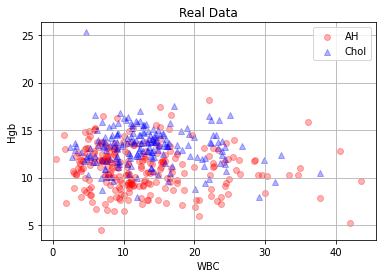

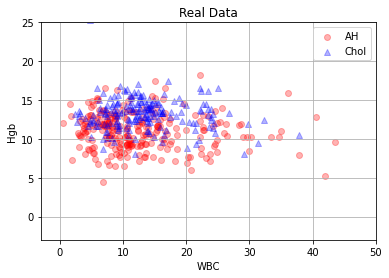

In [33]:
plot_data = torch.exp(data)
# plot_data = data
draw_data(plot_data[labels==0].cpu(), plot_data[labels==1].cpu(), \
          feature1 = 0, feature2 = 1, title_str='Real Data')
plt.grid(True)
plt.show()

plot_data = torch.exp(data)
# plot_data = data
draw_data(plot_data[labels==0].cpu(), plot_data[labels==1].cpu(), \
          feature1 = 0, feature2 = 1, title_str='Real Data')
plt.xlim(-3, 50)
plt.ylim(-3, 25)
plt.grid(True)
plt.show()


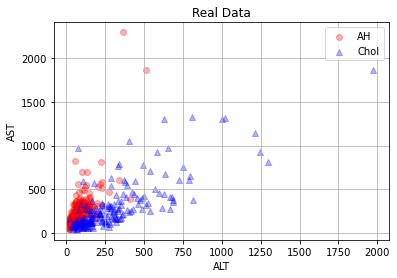

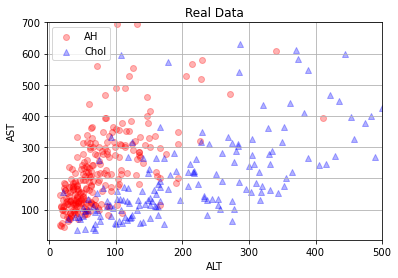

In [34]:
plot_data = torch.exp(data)
# plot_data = data
draw_data(plot_data[labels==0].cpu(), plot_data[labels==1].cpu(), \
          feature1 = 6, feature2 = 5, title_str='Real Data')
plt.grid(True)
plt.show()

plot_data = torch.exp(data)
# plot_data = data
draw_data(plot_data[labels==0].cpu(), plot_data[labels==1].cpu(), \
          feature1 = 6, feature2 = 5, title_str='Real Data')
plt.xlim(-3, 500)
plt.ylim(3, 700)
plt.grid(True)
plt.show()


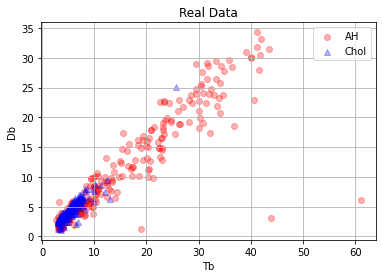

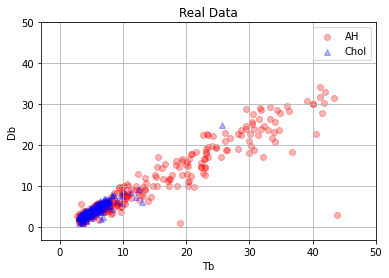

In [35]:
plot_data = torch.exp(data)
# plot_data = data
draw_data(plot_data[labels==0].cpu(), plot_data[labels==1].cpu(), \
          feature1 = 8, feature2 = 9, title_str='Real Data')
plt.grid(True)
plt.show()

plot_data = torch.exp(data)
# plot_data = data
draw_data(plot_data[labels==0].cpu(), plot_data[labels==1].cpu(), \
          feature1 = 8, feature2 = 9, title_str='Real Data')
plt.xlim(-3, 50)
plt.ylim(-3, 50)
plt.grid(True)
plt.show()


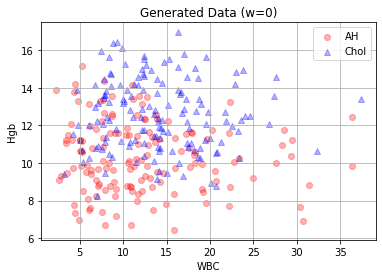

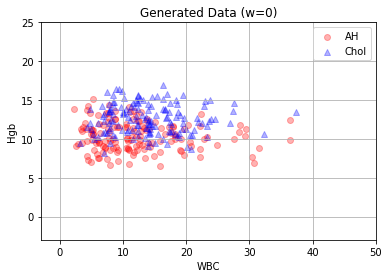

In [36]:
plot_data = torch.exp(generated)
# plot_data = generated
draw_data(plot_data[gen_labels==0].cpu(), plot_data[gen_labels==1].cpu(), \
          feature1 = 0, feature2 = 1, title_str='Generated Data (w=0)')
plt.grid(True)
plt.show()

plot_data = torch.exp(generated)
# plot_data = generated
draw_data(plot_data[gen_labels==0].cpu(), plot_data[gen_labels==1].cpu(), \
          feature1 = 0, feature2 = 1, title_str='Generated Data (w=0)')
plt.xlim(-3, 50)
plt.ylim(-3, 25)
plt.grid(True)
plt.show()


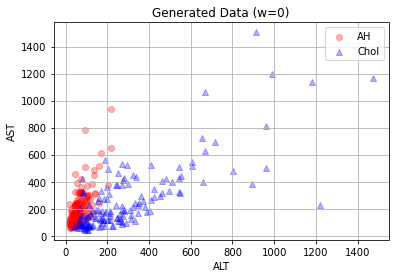

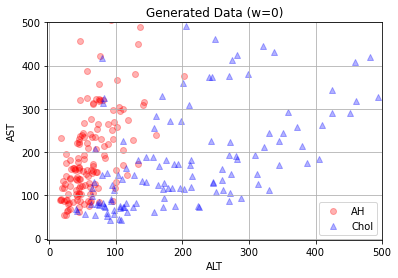

In [37]:
plot_data = torch.exp(generated)
# plot_data = generated
draw_data(plot_data[gen_labels==0].cpu(), plot_data[gen_labels==1].cpu(), \
          feature1 = 6, feature2 = 5, title_str='Generated Data (w=0)')
plt.grid(True)
plt.show()

plot_data = torch.exp(generated)
# plot_data = generated
draw_data(plot_data[gen_labels==0].cpu(), plot_data[gen_labels==1].cpu(), \
          feature1 = 6, feature2 = 5, title_str='Generated Data (w=0)')
plt.xlim(-3, 500)
plt.ylim(-3, 500)
plt.grid(True)
plt.show()


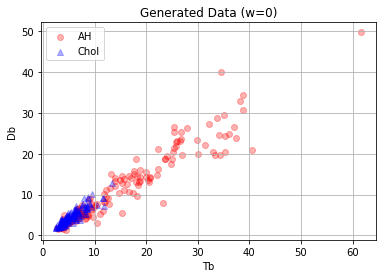

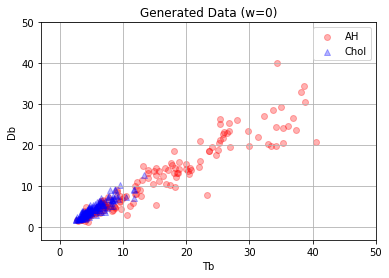

In [38]:
plot_data = torch.exp(generated)
# plot_data = generated
draw_data(plot_data[gen_labels==0].cpu(), plot_data[gen_labels==1].cpu(), \
          feature1 = 8, feature2 = 9, title_str='Generated Data (w=0)')
plt.grid(True)
plt.show()

plot_data = torch.exp(generated)
# plot_data = generated
draw_data(plot_data[gen_labels==0].cpu(), plot_data[gen_labels==1].cpu(), \
          feature1 = 8, feature2 = 9, title_str='Generated Data (w=0)')
plt.xlim(-3, 50)
plt.ylim(-3, 50)
plt.grid(True)
plt.show()


In [39]:
w_val = 0.5
n_gen = 300
gen_labels = torch.cat([torch.zeros(int(n_gen/2)), torch.ones(int(n_gen/2))])
generated = generate_new_data_cfg(
        best_model, n_gen, gen_labels,
        n_classes=n_classes,
        device=device,
        d = data.shape[1], 
        w_val=w_val
    )


In [40]:
df = pd.DataFrame(np.exp(generated[gen_labels==0].cpu()), columns=SelectedFeatures)
# df = pd.DataFrame(generated[gen_labels==0].cpu(), columns=SelectedFeatures)
df

,WBC,Hgb,MCV,Plt,ALB,AST,ALT,AP,TB,DB
0,tensor(24.0710),tensor(11.9454),tensor(95.2311),tensor(219.5110),tensor(2.6871),tensor(117.4492),tensor(29.4898),tensor(246.6594),tensor(29.3074),tensor(20.5636)
1,tensor(5.6058),tensor(10.7046),tensor(96.0948),tensor(112.2750),tensor(2.0730),tensor(282.4479),tensor(74.4999),tensor(315.3049),tensor(32.1436),tensor(21.6766)
2,tensor(13.3405),tensor(7.9618),tensor(92.0493),tensor(202.5361),tensor(2.3584),tensor(186.0079),tensor(22.5929),tensor(390.9185),tensor(5.0944),tensor(6.0821)
3,tensor(9.6522),tensor(10.7174),tensor(99.6599),tensor(76.9379),tensor(2.2376),tensor(163.2687),tensor(28.6543),tensor(275.3544),tensor(4.1921),tensor(2.5543)
4,tensor(6.9183),tensor(10.8120),tensor(125.2642),tensor(103.8778),tensor(2.0560),tensor(692.9329),tensor(190.1986),tensor(612.6748),tensor(35.8568),tensor(32.2841)
...,...,...,...,...,...,...,...,...,...,...
145,tensor(16.0534),tensor(7.9952),tensor(94.9902),tensor(327.4610),tensor(1.8721),tensor(170.4655),tensor(45.7992),tensor(143.9410),tensor(14.3907),tensor(12.1383)
146,tensor(15.9277),tensor(6.8462),tensor(107.2435),tensor(165.3091),tensor(2.9077),tensor(111.4782),tensor(28.1218),tensor(227.4567),tensor(16.7001),tensor(12.1554)
147,tensor(10.9773),tensor(9.4966),tensor(91.7232),tensor(45.8808),tensor(2.9057),tensor(103.9583),tensor(35.7766),tensor(232.2848),tensor(47.5382),tensor(38.4698)
148,tensor(17.5159),tensor(7.3454),tensor(110.3435),tensor(212.8258),tensor(2.7806),tensor(65.9281),tensor(22.4439),tensor(246.6669),tensor(27.8101),tensor(27.9069)


In [41]:
df = pd.DataFrame(np.exp(generated[gen_labels==1].cpu()), columns=SelectedFeatures)
# df = pd.DataFrame(generated[gen_labels==1].cpu(), columns=SelectedFeatures)
df

,WBC,Hgb,MCV,Plt,ALB,AST,ALT,AP,TB,DB
0,tensor(11.9574),tensor(11.6381),tensor(92.8647),tensor(277.1656),tensor(3.3731),tensor(253.9489),tensor(311.4886),tensor(155.4938),tensor(4.1463),tensor(3.6257)
1,tensor(14.5570),tensor(11.8381),tensor(88.6148),tensor(144.2488),tensor(3.0162),tensor(830.2773),tensor(557.6024),tensor(152.0571),tensor(3.3020),tensor(3.3592)
2,tensor(13.9466),tensor(12.6055),tensor(82.7489),tensor(151.1092),tensor(3.3166),tensor(125.2140),tensor(193.2845),tensor(108.4963),tensor(8.4649),tensor(6.2780)
3,tensor(19.5226),tensor(13.2037),tensor(92.3229),tensor(190.5247),tensor(2.7483),tensor(65.5194),tensor(102.4285),tensor(270.3557),tensor(4.9287),tensor(4.2436)
4,tensor(12.8145),tensor(11.3148),tensor(98.4697),tensor(164.3257),tensor(3.6825),tensor(311.3981),tensor(290.7618),tensor(259.4088),tensor(4.1297),tensor(2.8480)
...,...,...,...,...,...,...,...,...,...,...
145,tensor(17.6133),tensor(16.1771),tensor(87.7116),tensor(231.7374),tensor(3.3591),tensor(500.0203),tensor(243.7598),tensor(492.8345),tensor(4.7324),tensor(3.8360)
146,tensor(7.4374),tensor(11.5525),tensor(79.3674),tensor(320.5319),tensor(2.8441),tensor(37.8513),tensor(155.9615),tensor(658.5823),tensor(7.1369),tensor(5.4595)
147,tensor(8.7258),tensor(13.1308),tensor(102.3240),tensor(197.7684),tensor(3.8486),tensor(140.8573),tensor(152.5304),tensor(364.5685),tensor(4.5602),tensor(3.3327)
148,tensor(5.4648),tensor(14.8141),tensor(83.3309),tensor(138.9812),tensor(4.8722),tensor(49.5203),tensor(89.3421),tensor(101.3904),tensor(4.8043),tensor(2.5341)


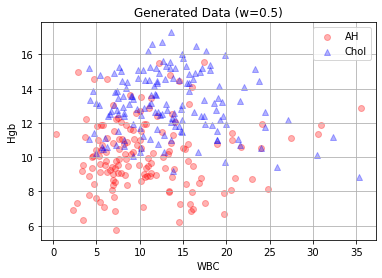

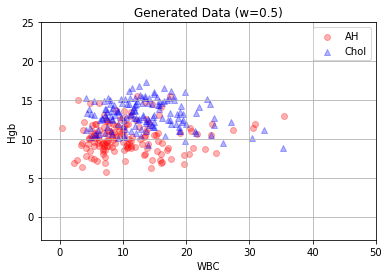

In [42]:
plot_data = torch.exp(generated)
# plot_data = generated
fig_title = "Generated Data (w=" + str(w_val) + ")"
draw_data(plot_data[gen_labels==0].cpu(), plot_data[gen_labels==1].cpu(), \
          feature1 = 0, feature2 = 1, title_str=fig_title)
plt.grid(True)
plt.show()

plot_data = torch.exp(generated)
# plot_data = generated
fig_title = "Generated Data (w=" + str(w_val) + ")"
draw_data(plot_data[gen_labels==0].cpu(), plot_data[gen_labels==1].cpu(), \
          feature1 = 0, feature2 = 1, title_str=fig_title)
plt.xlim(-3, 50)
plt.ylim(-3, 25)
plt.grid(True)
plt.show()


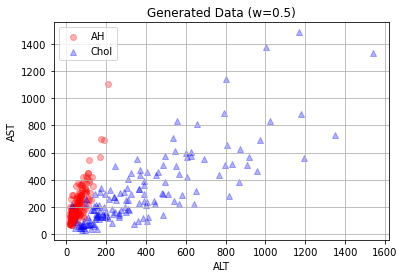

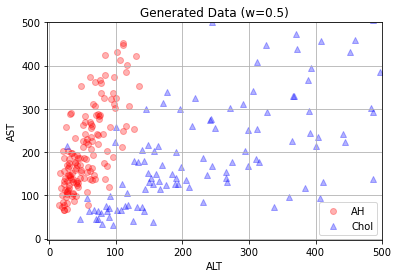

In [43]:
plot_data = torch.exp(generated)
# plot_data = generated
fig_title = "Generated Data (w=" + str(w_val) + ")"
draw_data(plot_data[gen_labels==0].cpu(), plot_data[gen_labels==1].cpu(), \
          feature1 = 6, feature2 = 5, title_str=fig_title)
plt.grid(True)
plt.show()

plot_data = torch.exp(generated)
# plot_data = generated
fig_title = "Generated Data (w=" + str(w_val) + ")"
draw_data(plot_data[gen_labels==0].cpu(), plot_data[gen_labels==1].cpu(), \
          feature1 = 6, feature2 = 5, title_str=fig_title)
plt.xlim(-3, 500)
plt.ylim(-3, 500)
plt.grid(True)
plt.show()


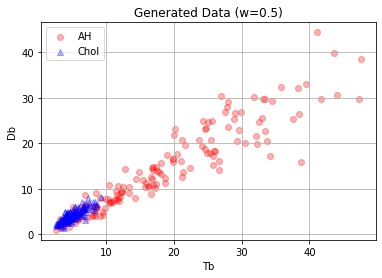

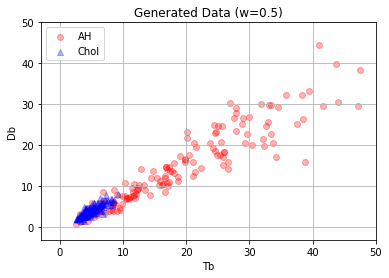

In [44]:
plot_data = torch.exp(generated)
# plot_data = generated
fig_title = "Generated Data (w=" + str(w_val) + ")"
draw_data(plot_data[gen_labels==0].cpu(), plot_data[gen_labels==1].cpu(), \
          feature1 = 8, feature2 = 9, title_str=fig_title)
plt.grid(True)
plt.show()

plot_data = torch.exp(generated)
# plot_data = generated
fig_title = "Generated Data (w=" + str(w_val) + ")"
draw_data(plot_data[gen_labels==0].cpu(), plot_data[gen_labels==1].cpu(), \
          feature1 = 8, feature2 = 9, title_str=fig_title)
plt.xlim(-3, 50)
plt.ylim(-3, 50)
plt.grid(True)
plt.show()


In [45]:
w_val = 1.
n_gen = 300
gen_labels = torch.cat([torch.zeros(int(n_gen/2)), torch.ones(int(n_gen/2))])
generated = generate_new_data_cfg(
        best_model, n_gen, gen_labels,
        n_classes=n_classes,
        device=device,
        d = data.shape[1],
        w_val=w_val
    )


In [46]:
df = pd.DataFrame(np.exp(generated[gen_labels==0].cpu()), columns=SelectedFeatures)
# df = pd.DataFrame(generated[gen_labels==0].cpu(), columns=SelectedFeatures)
df

,WBC,Hgb,MCV,Plt,ALB,AST,ALT,AP,TB,DB
0,tensor(2.1726),tensor(9.3020),tensor(112.1517),tensor(13.1307),tensor(3.0380),tensor(238.7701),tensor(73.9556),tensor(120.8324),tensor(6.8519),tensor(4.9317)
1,tensor(7.1388),tensor(6.4477),tensor(86.3265),tensor(26.5834),tensor(2.5301),tensor(140.5271),tensor(26.3528),tensor(106.5082),tensor(19.8602),tensor(15.5485)
2,tensor(7.1989),tensor(10.7582),tensor(79.4719),tensor(105.1595),tensor(2.1798),tensor(147.7386),tensor(31.7632),tensor(150.4344),tensor(24.6214),tensor(16.0436)
3,tensor(14.7704),tensor(6.3325),tensor(106.8294),tensor(62.1427),tensor(2.5575),tensor(109.6696),tensor(32.7654),tensor(94.3940),tensor(37.0351),tensor(26.0723)
4,tensor(16.4670),tensor(12.0264),tensor(87.1606),tensor(136.4807),tensor(2.3836),tensor(107.3416),tensor(49.1859),tensor(161.5388),tensor(26.5574),tensor(18.7300)
...,...,...,...,...,...,...,...,...,...,...
145,tensor(5.0186),tensor(8.2628),tensor(93.3652),tensor(172.1372),tensor(2.3975),tensor(227.9167),tensor(40.3128),tensor(142.3452),tensor(13.3630),tensor(10.2217)
146,tensor(17.1158),tensor(7.6354),tensor(115.5054),tensor(155.4539),tensor(3.3130),tensor(52.5326),tensor(13.7885),tensor(67.5563),tensor(13.5013),tensor(9.7755)
147,tensor(13.2780),tensor(7.0403),tensor(82.8670),tensor(127.3698),tensor(2.4634),tensor(116.8471),tensor(24.2341),tensor(424.6682),tensor(14.7606),tensor(12.5842)
148,tensor(5.8043),tensor(8.4880),tensor(94.2110),tensor(37.3428),tensor(2.1575),tensor(132.7957),tensor(54.2346),tensor(119.7249),tensor(38.7800),tensor(26.1866)


In [47]:
df = pd.DataFrame(np.exp(generated[gen_labels==1].cpu()), columns=SelectedFeatures)
# df = pd.DataFrame(generated[gen_labels==1].cpu(), columns=SelectedFeatures)
df

,WBC,Hgb,MCV,Plt,ALB,AST,ALT,AP,TB,DB
0,tensor(7.1207),tensor(12.5045),tensor(81.6720),tensor(255.1127),tensor(3.7440),tensor(446.6495),tensor(421.9749),tensor(303.5046),tensor(4.0792),tensor(2.4837)
1,tensor(15.8465),tensor(12.0336),tensor(96.0124),tensor(191.0947),tensor(2.7750),tensor(343.1908),tensor(808.5896),tensor(480.4461),tensor(4.3215),tensor(3.5783)
2,tensor(6.4096),tensor(11.7485),tensor(69.8093),tensor(304.0424),tensor(4.2278),tensor(167.6487),tensor(264.7242),tensor(91.7451),tensor(8.1344),tensor(6.3219)
3,tensor(17.2011),tensor(12.0263),tensor(92.3800),tensor(198.1378),tensor(2.8381),tensor(122.2824),tensor(206.4777),tensor(862.9645),tensor(7.2657),tensor(6.7271)
4,tensor(10.5892),tensor(12.4558),tensor(84.2954),tensor(146.1519),tensor(2.2714),tensor(130.2449),tensor(305.4069),tensor(1427.0325),tensor(3.9314),tensor(4.1923)
...,...,...,...,...,...,...,...,...,...,...
145,tensor(19.6788),tensor(12.1523),tensor(85.9670),tensor(214.1670),tensor(3.2125),tensor(251.9339),tensor(198.6054),tensor(136.2630),tensor(3.5074),tensor(2.8072)
146,tensor(14.7619),tensor(9.2609),tensor(76.4290),tensor(115.4398),tensor(3.9272),tensor(653.6320),tensor(960.5916),tensor(395.2027),tensor(6.2310),tensor(5.2440)
147,tensor(10.2255),tensor(8.4205),tensor(79.7828),tensor(85.9006),tensor(3.3913),tensor(201.3638),tensor(325.1906),tensor(134.6592),tensor(2.5553),tensor(2.5531)
148,tensor(17.3505),tensor(12.3795),tensor(88.7496),tensor(205.8230),tensor(3.0364),tensor(353.4553),tensor(556.0411),tensor(224.0358),tensor(3.9790),tensor(3.5784)


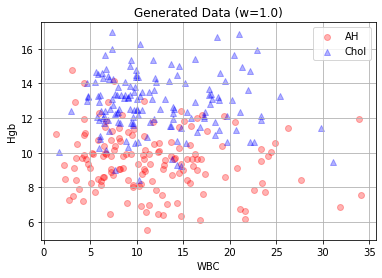

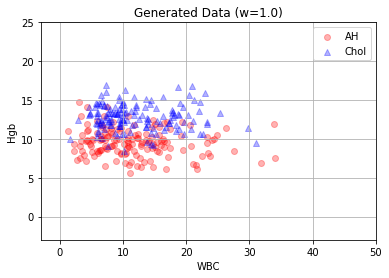

In [48]:
plot_data = torch.exp(generated)
# plot_data = generated
# draw_data(plot_data[gen_labels==0].cpu(), plot_data[gen_labels==1].cpu(), \
#           feature1 = 0, feature2 = 1, title_str='Generated Data')
fig_title = "Generated Data (w=" + str(w_val) + ")"
draw_data(plot_data[gen_labels==0].cpu(), plot_data[gen_labels==1].cpu(), \
          feature1 = 0, feature2 = 1, title_str=fig_title)
plt.grid(True)
plt.show()

plot_data = torch.exp(generated)
# plot_data = generated
fig_title = "Generated Data (w=" + str(w_val) + ")"
draw_data(plot_data[gen_labels==0].cpu(), plot_data[gen_labels==1].cpu(), \
          feature1 = 0, feature2 = 1, title_str=fig_title)
plt.xlim(-3, 50)
plt.ylim(-3, 25)
plt.grid(True)
plt.show()

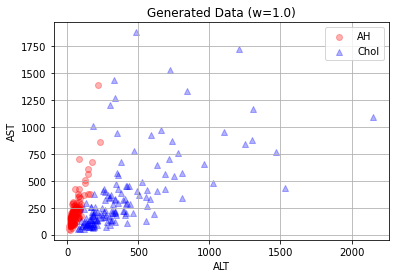

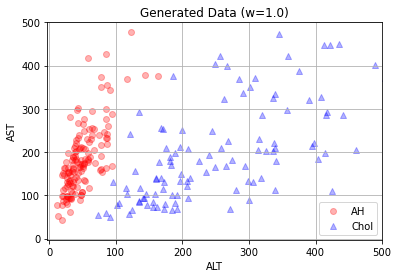

In [49]:
plot_data = torch.exp(generated)
# plot_data = generated
fig_title = "Generated Data (w=" + str(w_val) + ")"
draw_data(plot_data[gen_labels==0].cpu(), plot_data[gen_labels==1].cpu(), \
          feature1 = 6, feature2 = 5, title_str=fig_title)
plt.grid(True)
plt.show()

plot_data = torch.exp(generated)
# plot_data = generated
fig_title = "Generated Data (w=" + str(w_val) + ")"
draw_data(plot_data[gen_labels==0].cpu(), plot_data[gen_labels==1].cpu(), \
          feature1 = 6, feature2 = 5, title_str=fig_title)
plt.xlim(-3, 500)
plt.ylim(-3, 500)
plt.grid(True)
plt.show()


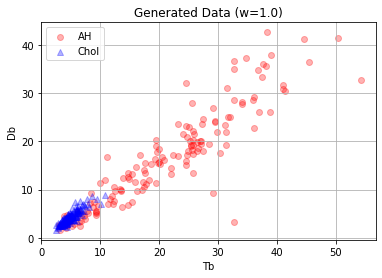

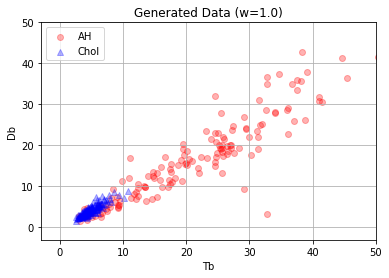

In [50]:
plot_data = torch.exp(generated)
# plot_data = generated
fig_title = "Generated Data (w=" + str(w_val) + ")"
draw_data(plot_data[gen_labels==0].cpu(), plot_data[gen_labels==1].cpu(), \
          feature1 = 8, feature2 = 9, title_str=fig_title)
plt.grid(True)
plt.show()

plot_data = torch.exp(generated)
# plot_data = generated
fig_title = "Generated Data (w=" + str(w_val) + ")"
draw_data(plot_data[gen_labels==0].cpu(), plot_data[gen_labels==1].cpu(), \
          feature1 = 8, feature2 = 9, title_str=fig_title)
plt.xlim(-3, 50)
plt.ylim(-3, 50)
plt.grid(True)
plt.show()


In [51]:
w_val = 2.
n_gen = 300
gen_labels = torch.cat([torch.zeros(int(n_gen/2)), torch.ones(int(n_gen/2))])
generated = generate_new_data_cfg(
        best_model, n_gen, gen_labels,
        n_classes=n_classes,
        device=device,
        d = data.shape[1], w_val=w_val
    )


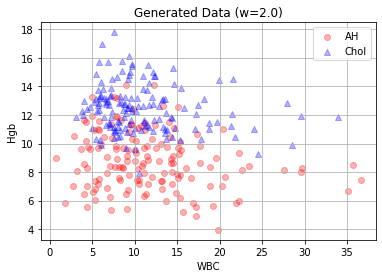

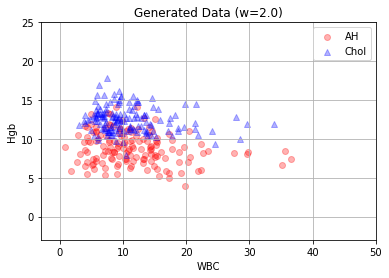

In [52]:
plot_data = torch.exp(generated)
# plot_data = generated
fig_title = "Generated Data (w=" + str(w_val) + ")"
draw_data(plot_data[gen_labels==0].cpu(), plot_data[gen_labels==1].cpu(), \
          feature1 = 0, feature2 = 1, title_str=fig_title)
# draw_data(plot_data[gen_labels==0].cpu(), plot_data[gen_labels==1].cpu(), \
#           feature1 = 0, feature2 = 1, title_str='Generated Data')
plt.grid(True)
plt.show()

plot_data = torch.exp(generated)
# plot_data = generated
fig_title = "Generated Data (w=" + str(w_val) + ")"
draw_data(plot_data[gen_labels==0].cpu(), plot_data[gen_labels==1].cpu(), \
          feature1 = 0, feature2 = 1, title_str=fig_title)
plt.xlim(-3, 50)
plt.ylim(-3, 25)
plt.grid(True)
plt.show()

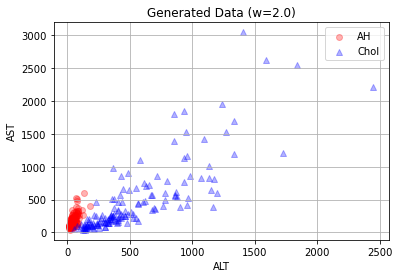

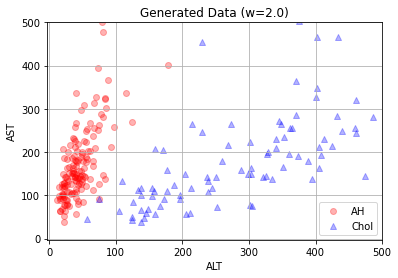

In [53]:
plot_data = torch.exp(generated)
# plot_data = generated
fig_title = "Generated Data (w=" + str(w_val) + ")"
draw_data(plot_data[gen_labels==0].cpu(), plot_data[gen_labels==1].cpu(), \
          feature1 = 6, feature2 = 5, title_str=fig_title)
plt.grid(True)
plt.show()

plot_data = torch.exp(generated)
# plot_data = generated
fig_title = "Generated Data (w=" + str(w_val) + ")"
draw_data(plot_data[gen_labels==0].cpu(), plot_data[gen_labels==1].cpu(), \
          feature1 = 6, feature2 = 5, title_str=fig_title)
plt.xlim(-3, 500)
plt.ylim(-3, 500)
plt.grid(True)
plt.show()


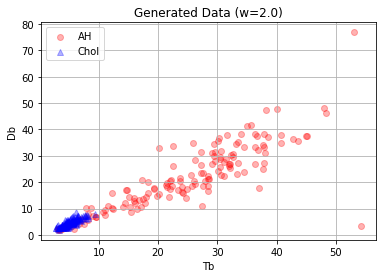

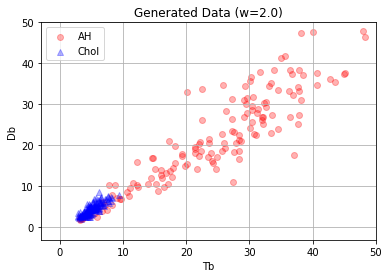

In [54]:
plot_data = torch.exp(generated)
# plot_data = generated
fig_title = "Generated Data (w=" + str(w_val) + ")"
draw_data(plot_data[gen_labels==0].cpu(), plot_data[gen_labels==1].cpu(), \
          feature1 = 8, feature2 = 9, title_str=fig_title)
plt.grid(True)
plt.show()

plot_data = torch.exp(generated)
# plot_data = generated
fig_title = "Generated Data (w=" + str(w_val) + ")"
draw_data(plot_data[gen_labels==0].cpu(), plot_data[gen_labels==1].cpu(), \
          feature1 = 8, feature2 = 9, title_str=fig_title)
plt.xlim(-3, 50)
plt.ylim(-3, 50)
plt.grid(True)
plt.show()
